In [26]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
# import seaborn as sns

from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold, cross_val_score
from sklearn.feature_selection import RFECV
from sklearn.pipeline import Pipeline

from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.metrics import classification_report

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:60% !important; }</style>"))

In [11]:
df_test = pd.read_csv('contest_test.csv')
df_train = pd.read_csv('contest_train.csv')

In [12]:
df_train.sample(5)

,ID,FEATURE_0,FEATURE_1,FEATURE_2,FEATURE_3,FEATURE_4,FEATURE_5,FEATURE_6,FEATURE_7,FEATURE_8,...,FEATURE_251,FEATURE_252,FEATURE_253,FEATURE_254,FEATURE_255,FEATURE_256,FEATURE_257,FEATURE_258,FEATURE_259,TARGET
6521,1098708299,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-35.270147,21.673188,...,0.0,62.962566,57.368314,0.0,0.0,0.0,1.0,1.0,2.0,0
15036,1153861473,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.237659,-92.356700,...,0.0,194.142684,229.890831,1.0,0.0,0.0,1.0,1.0,1.0,1
9624,359971542,1.0,1.0,0.0,0.0,0.0,0.0,0.0,22.725415,-2.017662,...,0.0,53.736818,5.426700,1.0,0.0,0.0,1.0,1.0,1.0,0
6693,86894981,2.0,1.0,0.0,0.0,0.0,0.0,1.0,459.063807,27.007450,...,140.0,175.085116,516.337577,0.0,0.0,0.0,1.0,1.0,1.0,1
15054,10299389477,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-56.133671,-17.267171,...,0.0,63.247470,34.308676,1.0,0.0,0.0,1.0,2.0,2.0,2


In [13]:
df_train.index = df_train.ID
df_train.drop(columns=['ID'], inplace=True)

## #0 EDA

In [14]:
df_train.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18390 entries, 737005990 to 5118995640
Data columns (total 261 columns):
 #    Column       Non-Null Count  Dtype  
---   ------       --------------  -----  
 0    FEATURE_0    18390 non-null  float64
 1    FEATURE_1    18390 non-null  float64
 2    FEATURE_2    18390 non-null  float64
 3    FEATURE_3    18390 non-null  float64
 4    FEATURE_4    18390 non-null  float64
 5    FEATURE_5    18390 non-null  float64
 6    FEATURE_6    18390 non-null  float64
 7    FEATURE_7    18390 non-null  float64
 8    FEATURE_8    17497 non-null  float64
 9    FEATURE_9    18390 non-null  float64
 10   FEATURE_10   18390 non-null  float64
 11   FEATURE_11   18390 non-null  float64
 12   FEATURE_12   18375 non-null  float64
 13   FEATURE_13   18390 non-null  float64
 14   FEATURE_14   18390 non-null  float64
 15   FEATURE_15   18390 non-null  float64
 16   FEATURE_16   18390 non-null  float64
 17   FEATURE_17   18390 non-null  float64
 18   FEATURE_18 

* есть пропуски, текстовые категории отсутствуют

### #0_1 Проверка сбалансированности целевой переменной

In [15]:
df_target = df_train['TARGET']
target = df_target.to_list()
df_target.value_counts()


0    13029
1     4237
2     1124
Name: TARGET, dtype: int64

###### датасет является не сбалансированным, сначала поработаем с таким, и при необходимости воспользуемся балансировкой

### #0_2 работа с пропусками и константными столбцами

In [16]:
# Создам список столбцов содержащих только одно уникальное значение
const_columns = [i for i in df_train.columns if df_train[i].unique().size == 1]
print('Столбцы c одним уникальным значением:')
print(const_columns)

# Удалю константные столбцы
df_train.drop(columns=const_columns, inplace=True)

# Сохраню все списки столбцов которые будут удалены в один
columns_droped = const_columns
print()
print(f'Список удаленных столбцов (ВСЕГО {len(columns_droped)}):')
print(columns_droped)

Столбцы c одним уникальным значением:
['FEATURE_3', 'FEATURE_144', 'FEATURE_249', 'FEATURE_256']

Список удаленных столбцов (ВСЕГО 4):
['FEATURE_3', 'FEATURE_144', 'FEATURE_249', 'FEATURE_256']


In [17]:
# Создам список столбцов содержащие Nan
nan_columns = [i for i in df_train.columns if df_train[i].isnull().any()]
print('Имя столбца и количество содержащие nan:')
df_train[nan_columns].isnull().sum()

Имя столбца и количество содержащие nan:


FEATURE_8        893
FEATURE_12        15
FEATURE_71      2189
FEATURE_72      2069
FEATURE_73      2189
FEATURE_123      218
FEATURE_124      218
FEATURE_125      218
FEATURE_126      218
FEATURE_127      218
FEATURE_128      218
FEATURE_129      218
FEATURE_130      218
FEATURE_131      218
FEATURE_132      218
FEATURE_133      218
FEATURE_134      218
FEATURE_135      218
FEATURE_136      218
FEATURE_137      218
FEATURE_138      218
FEATURE_149     1824
FEATURE_150     1824
FEATURE_151     1824
FEATURE_152     1824
FEATURE_153     1824
FEATURE_162      487
FEATURE_173       20
FEATURE_174       20
FEATURE_175       98
FEATURE_181       92
FEATURE_183        1
FEATURE_187     8857
FEATURE_188      773
FEATURE_189    18146
FEATURE_190    12889
FEATURE_191    11451
FEATURE_192     9752
FEATURE_193     9382
FEATURE_194    12952
FEATURE_195     2074
FEATURE_196      356
FEATURE_203       94
FEATURE_204      100
FEATURE_205       98
FEATURE_206       91
FEATURE_207       97
FEATURE_208  

###### Имеются колонки содержащие много пропусков, колонки в которых >60% удалим, остальные рассмотрим подробнее

In [18]:
nan_columns_more_60perc = [i for i in df_train.columns if df_train[i].isnull().sum()/len(df_train) > 0.6]
print('Столбцы с долей пропусков >60%:')
print(nan_columns_more_60perc)

# Удалю столбцы с пропуском >60%
df_train.drop(columns=nan_columns_more_60perc, inplace=True)

# Расширю список столбцов которые будут удалены
columns_droped.extend(nan_columns_more_60perc)
print()
print(f'Список удаленных столбцов (ВСЕГО {len(columns_droped)}):')
print(columns_droped)

Столбцы с долей пропусков >60%:
['FEATURE_189', 'FEATURE_190', 'FEATURE_191', 'FEATURE_194']

Список удаленных столбцов (ВСЕГО 8):
['FEATURE_3', 'FEATURE_144', 'FEATURE_249', 'FEATURE_256', 'FEATURE_189', 'FEATURE_190', 'FEATURE_191', 'FEATURE_194']


In [19]:
column_target = 'TARGET'
def analysis_nan(df, columns, column_target):
    """Функция выводит коэф. корреляции Спирмана и основные стат показатели"""
    
    full_columns = columns.copy()
    full_columns.append(column_target)
    print('############ Коэф. коореляции Спирмана ############')
    display(df[full_columns].corr(method='spearman'))
    print('')
    print('############ Основные статистические показатели ############')
    display(df[full_columns].describe())

    return

In [20]:
# Рассмотрим колонки с пропуском >30%
nan_columns_more_30perc =[i for i in df_train.columns if df_train[i].isnull().sum()/len(df_train) > 0.3]
analysis_nan(df_train, nan_columns_more_30perc, column_target)

############ Коэф. коореляции Спирмана ############


,FEATURE_187,FEATURE_192,FEATURE_193,TARGET
FEATURE_187,1.000000,0.807562,0.828951,-0.000772
FEATURE_192,0.807562,1.000000,0.818930,0.003909
FEATURE_193,0.828951,0.818930,1.000000,0.003222
TARGET,-0.000772,0.003909,0.003222,1.000000



############ Основные статистические показатели ############


,FEATURE_187,FEATURE_192,FEATURE_193,TARGET
count,9533.000000,8638.000000,9008.000000,18390.000000
mean,358.085485,392.181972,386.317853,0.352637
std,370.763763,388.154148,391.549902,0.592067
min,-114.825121,-188.399565,-219.011688,0.000000
25%,84.164489,94.792575,92.409424,0.000000
50%,191.847825,217.061513,205.964336,0.000000
75%,540.171773,586.294155,575.073791,1.000000
max,1591.154993,1523.790747,1535.146770,2.000000


###### колонки(nan > 30%) сильно скоррелированы между собой(порождает мультиколлинеарность) и слабо с целевой переменной, значит удаляем

In [21]:
print('Столбцы с долей пропусков >30%:')
print(nan_columns_more_30perc)

# Удалю столбцы с пропуском >30%
df_train.drop(columns=nan_columns_more_30perc, inplace=True)

# Расширю список столбцов которые будут удалены
columns_droped.extend(nan_columns_more_30perc)
print()
print(f'Список удаленных столбцов (ВСЕГО {len(columns_droped)}):')
print(columns_droped)

Столбцы с долей пропусков >30%:
['FEATURE_187', 'FEATURE_192', 'FEATURE_193']

Список удаленных столбцов (ВСЕГО 11):
['FEATURE_3', 'FEATURE_144', 'FEATURE_249', 'FEATURE_256', 'FEATURE_189', 'FEATURE_190', 'FEATURE_191', 'FEATURE_194', 'FEATURE_187', 'FEATURE_192', 'FEATURE_193']


In [22]:
# Рассмотрим колонки с пропуском >10%
nan_columns_more_10perc = [i for i in df_train.columns if df_train[i].isnull().sum()/len(df_train) > 0.1]
analysis_nan(df_train, nan_columns_more_10perc, column_target)

############ Коэф. коореляции Спирмана ############


,FEATURE_71,FEATURE_72,FEATURE_73,FEATURE_195,TARGET
FEATURE_71,1.000000,0.637001,0.730298,0.682415,0.084809
FEATURE_72,0.637001,1.000000,0.644897,0.661918,0.055039
FEATURE_73,0.730298,0.644897,1.000000,0.675905,0.073892
FEATURE_195,0.682415,0.661918,0.675905,1.000000,0.068645
TARGET,0.084809,0.055039,0.073892,0.068645,1.000000



############ Основные статистические показатели ############


,FEATURE_71,FEATURE_72,FEATURE_73,FEATURE_195,TARGET
count,16201.000000,16321.000000,16201.000000,16316.000000,18390.000000
mean,152.906029,127.891001,140.092709,140.391302,0.352637
std,292.724920,281.191874,285.623639,289.841496,0.592067
min,-155.267663,-154.932496,-170.491157,-206.136218,0.000000
25%,0.719108,-5.496852,-2.551014,-3.266776,0.000000
50%,27.640968,12.133847,19.686110,18.367690,0.000000
75%,152.848156,91.488524,125.623045,121.880849,1.000000
max,1824.004390,1804.983548,1804.740840,1804.447553,2.000000


###### колонки(nan > 10%) тенденция взаимной корреляции и с целевой переменной улучшается, т.к. данных пропущено не так много, то посмотрим на корреляцию по остальным предиктором и либо удалим, либо заполним пропуски

In [23]:
corr_sp = df_train.corr(method='spearman')

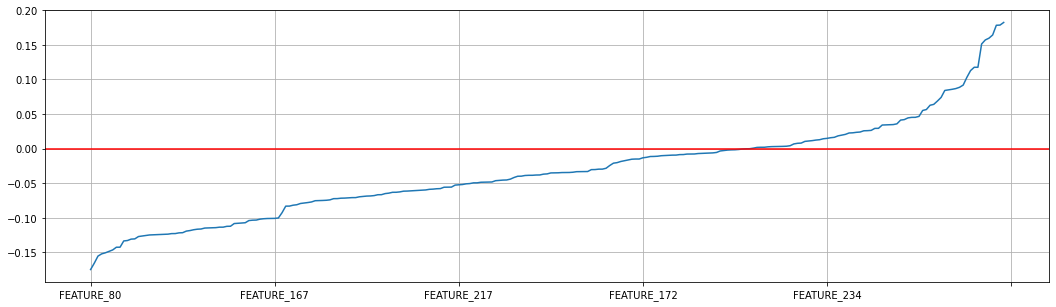

In [27]:
corr_sp[corr_sp.index != 'TARGET']['TARGET'].sort_values().plot(figsize=(18, 5))
plt.axhline(y=0, color='r')
plt.grid()

In [28]:
corr_sp[corr_sp.index != 'TARGET']['TARGET'].abs().describe()

count    249.000000
mean       0.060634
std        0.046146
min        0.000284
25%        0.020430
50%        0.052070
75%        0.100472
max        0.182344
Name: TARGET, dtype: float64

###### колонки с пропусками > 10%, имеют степень корреляции с таргетом между 0,5 и 0,75 квантилях распределения корреляций всех предикторов, поэтому относительная скоррелированность высока и будем заполнять эти и остальные пропуски, по графику всех корреляций видно, что имеются предикторы с около нулевым коэф корреляции, такие предикторы следует исключить из обучающего датасета

In [29]:
columnn_coef_corr = corr_sp[corr_sp.index != 'TARGET']['TARGET'].abs().sort_values()
columnn_low_coef_corr = columnn_coef_corr[columnn_coef_corr < 0.05].index.to_list()
df_train.drop(columns=columnn_low_coef_corr, inplace=True)

# Расширю список столбцов которые будут удалены
columns_droped.extend(columnn_low_coef_corr)
print()
print(f'Список удаленных столбцов (ВСЕГО {len(columns_droped)}):')
print(columns_droped)


Список удаленных столбцов (ВСЕГО 133):
['FEATURE_3', 'FEATURE_144', 'FEATURE_249', 'FEATURE_256', 'FEATURE_189', 'FEATURE_190', 'FEATURE_191', 'FEATURE_194', 'FEATURE_187', 'FEATURE_192', 'FEATURE_193', 'FEATURE_259', 'FEATURE_30', 'FEATURE_42', 'FEATURE_107', 'FEATURE_108', 'FEATURE_196', 'FEATURE_141', 'FEATURE_140', 'FEATURE_5', 'FEATURE_146', 'FEATURE_28', 'FEATURE_123', 'FEATURE_6', 'FEATURE_247', 'FEATURE_169', 'FEATURE_41', 'FEATURE_24', 'FEATURE_171', 'FEATURE_44', 'FEATURE_159', 'FEATURE_174', 'FEATURE_224', 'FEATURE_12', 'FEATURE_32', 'FEATURE_14', 'FEATURE_27', 'FEATURE_246', 'FEATURE_229', 'FEATURE_219', 'FEATURE_226', 'FEATURE_21', 'FEATURE_20', 'FEATURE_142', 'FEATURE_220', 'FEATURE_231', 'FEATURE_25', 'FEATURE_176', 'FEATURE_43', 'FEATURE_29', 'FEATURE_19', 'FEATURE_23', 'FEATURE_16', 'FEATURE_22', 'FEATURE_8', 'FEATURE_39', 'FEATURE_258', 'FEATURE_40', 'FEATURE_145', 'FEATURE_172', 'FEATURE_97', 'FEATURE_234', 'FEATURE_18', 'FEATURE_143', 'FEATURE_26', 'FEATURE_31', 'F

In [30]:
# # Т.к. датасет не сбалансирован, то можно удалить строки с пропусками в колонках >10% и таргетом равный 0, тогда датасет частично сбалансируется, а заполнение 
# # оставшейся малой доли пропусков менее исказит стат показатели относительно исходного датасета
# rowsNaN_of_columns_NaN10perc = set(df_train[(df_train[nan_columns_more_10perc[0]].isnull() & df_train[nan_columns_more_10perc[1]].isnull() \
#           & df_train[nan_columns_more_10perc[2]].isnull() & df_train[nan_columns_more_10perc[3]].isnull())].index)
# rows_target_0 = set(df_train[df_train['TARGET'] == 0].index)
# drop_rows_NaN10prc_TARGET_0 = rowsNaN_of_columns_NaN10perc & rows_target_0 # пересечение двух множеств


# # Данный метод "законсервирован", т.к. посчитал, что не является универсальным средством

* Заполнять пропуски буду с помощью  KNN

In [31]:
imputer = KNNImputer(n_neighbors=5, missing_values=np.nan)
value_notnull = imputer.fit_transform(df_train)
df_KNN = pd.DataFrame(data=value_notnull, index=df_train.index, columns=df_train.columns).convert_dtypes()
df_KNN

,FEATURE_45,FEATURE_46,FEATURE_47,FEATURE_48,FEATURE_49,FEATURE_50,FEATURE_51,FEATURE_52,FEATURE_53,FEATURE_54,...,FEATURE_239,FEATURE_240,FEATURE_242,FEATURE_244,FEATURE_250,FEATURE_252,FEATURE_253,FEATURE_254,FEATURE_255,TARGET
ID,,,,,,,,,,,,,,,,,,,,,
737005990,-13.84664,-4.867411,138.356993,41.342282,26.000672,3.534147,16.113696,2.646936,115.196945,-0.230957,...,2,111.195748,0,68.404615,1,65.729608,68.56661,0,0,0
336625142,-26.179239,58.785172,13.311758,-11.533431,-17.220208,-18.644461,8.790456,43.073745,31.073687,-12.815185,...,132,126.430181,0,19.842984,4,70.623966,72.159259,1,0,0
1146317240,56.341593,97.74415,2.036722,-8.813739,-5.815092,23.376911,92.579331,21.649568,10.364292,15.033361,...,41,497.85703,0,412.343922,0,475.810787,603.267435,1,1,2
1152334700,1440.54363,116.851382,285.124007,628.737637,430.248129,462.435865,2259.064544,1593.24938,644.195852,2559.431051,...,56,222.525255,0,185.679568,0,140.54332,212.539669,1,1,0
1148871905,3922.767431,20063.360092,40.765463,631.904322,30976.916398,-43.208449,4067.699441,20747.268085,214.286804,1832.155889,...,35,929.868814,0,409.829116,0,417.804418,430.329005,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110510537,11.780151,5.763279,7.909698,-35.723353,22.61396,8.590733,8.432538,-5.530811,85.35798,-27.065533,...,139,350.993226,0,274.604315,0,229.898575,267.51881,1,0,0
563201878,12.623879,-59.936132,-8.242173,4.900051,5.329612,68.716209,-24.699515,-51.563154,45.96218,135.022928,...,458,885.501655,3,-61.331492,17,216.50512,629.65184,1,1,0
635029020,2247.451852,8922.707335,208.115269,380.011026,5172.538465,14181.442474,2247.058639,8878.649395,227.44816,283.729198,...,73,447.766888,0,280.563158,21,248.237417,527.271853,1,1,1


In [32]:
# print(df_train[nan_columns_more_10perc].describe())
# print()
# print("########### Сравнение основных стат показателей исходного и заполненного dataframe #############")
# print()
# print(df_KNN[nan_columns_more_10perc].describe())

## #1 Подготовка данных

In [33]:
# Выделю целевую переменую в отдельную сущность и удалю из предикторов
target = df_train['TARGET'].to_list()
df_KNN.drop(columns=['TARGET'], inplace=True)

### #1_1 Нормализация данных

In [34]:
# StandardScaler 
sc = StandardScaler()
df_knn_sc = sc.fit_transform(df_KNN)
df_knn_sc = pd.DataFrame(data=df_knn_sc, index=df_KNN.index, columns=df_KNN.columns)
df_knn_sc.head()

,FEATURE_45,FEATURE_46,FEATURE_47,FEATURE_48,FEATURE_49,FEATURE_50,FEATURE_51,FEATURE_52,FEATURE_53,FEATURE_54,...,FEATURE_238,FEATURE_239,FEATURE_240,FEATURE_242,FEATURE_244,FEATURE_250,FEATURE_252,FEATURE_253,FEATURE_254,FEATURE_255
ID,,,,,,,,,,,,,,,,,,,,,
737005990,-0.333108,-0.326323,-0.286035,-0.316975,-0.309590,-0.323581,-0.351946,-0.356605,-0.340481,-0.365621,...,-0.633933,-0.802837,-0.841790,-0.180316,-0.609038,-0.382597,-0.929286,-0.969304,-1.257543,-1.338763
336625142,-0.336197,-0.311323,-0.314124,-0.328453,-0.318278,-0.328186,-0.353334,-0.349559,-0.354601,-0.367548,...,0.270315,0.183896,-0.795532,-0.180316,-0.809984,-0.354166,-0.910594,-0.959125,0.795201,-1.338763
1146317240,-0.315526,-0.302142,-0.316657,-0.327863,-0.315985,-0.319461,-0.337445,-0.353293,-0.358077,-0.363283,...,-0.609159,-0.506817,0.332259,-0.180316,0.814172,-0.392075,0.636786,0.545698,0.795201,0.746958
1152334700,0.031217,-0.297639,-0.253066,-0.189468,-0.228330,-0.228293,0.073407,-0.079362,-0.251688,0.026352,...,-0.287098,-0.392963,-0.503752,-0.180316,-0.123758,-0.392075,-0.643577,-0.561376,0.795201,0.746958
1148871905,0.653014,4.402969,-0.307957,-0.188780,5.912027,-0.333287,0.416397,3.259198,-0.323848,-0.085019,...,-0.510064,-0.552358,1.644008,-0.180316,0.803766,-0.392075,0.415263,0.055700,-1.257543,0.746958


### #1_2 Разбиение на train/test

In [35]:
X_train, X_test, y_train, y_test = train_test_split(df_knn_sc.values, target, test_size=0.2, random_state=0)

## #2 Baseline ML

In [42]:
# model Logistic Regression
model_LR = LogisticRegression(multi_class='ovr', tol=0.001, max_iter=800, class_weight='balanced', solver='saga', penalty='elasticnet', C=0.1, l1_ratio=0.6, random_state=0, n_jobs=-1)
model_LR.fit(X_train, y_train)
LR_pred = model_LR.predict(X_test)


In [37]:
# model Support Vector Classification
model_svc = SVC(decision_function_shape='ovo', class_weight='balanced')
model_svc.fit(X_train, y_train)
SVC_pred = model_svc.predict(X_test)

In [38]:
# model K-Nearest Neighbors
model_KNN = KNeighborsClassifier()
model_KNN.fit(X_train, y_train)
KNN_pred = model_KNN.predict(X_test)

In [39]:
# model Decision Tree
model_DT = DecisionTreeClassifier(class_weight='balanced')
model_DT.fit(X_train, y_train)
DT_pred = model_DT.predict(X_test)

In [40]:
print("LR Classification Report: \n", classification_report(y_test, LR_pred, digits = 5))
print("SVC Classification Report: \n", classification_report(y_test, SVC_pred, digits = 5))
print("KNN Classification Report: \n", classification_report(y_test, KNN_pred, digits = 5))
print("DT Classification Report: \n", classification_report(y_test, DT_pred, digits = 5))

LR Classification Report: 
               precision    recall  f1-score   support

           0    0.79041   0.59662   0.67997      2541
           1    0.34684   0.40175   0.37228       916
           2    0.24464   0.77376   0.37174       221

    accuracy                        0.55873      3678
   macro avg    0.46063   0.59071   0.47466      3678
weighted avg    0.64714   0.55873   0.58482      3678

SVC Classification Report: 
               precision    recall  f1-score   support

           0    0.78993   0.60527   0.68538      2541
           1    0.34244   0.41048   0.37339       916
           2    0.25592   0.73303   0.37939       221

    accuracy                        0.56444      3678
   macro avg    0.46277   0.58293   0.47939      3678
weighted avg    0.64640   0.56444   0.58929      3678

KNN Classification Report: 
               precision    recall  f1-score   support

           0    0.71357   0.89610   0.79449      2541
           1    0.32282   0.14520   0.20030

## #3 Tuning ML
#### В модели использовалось >100 фичей, некоторые из них могут вносить искажения в качество модели, также нужно исключить влияние рандомного разбиения на train\test для этого будет использована кросс-валидация.
  
#### 1. Будем подбирать гиперпараметры с помощью GridSearch

#### 2. Буду подробнее изучать влияние мультиколлинеарности

#### 2.1. Выделение наиболее весомых фичей с использование кросс-валидации и применим их в модели 

### Уменьшение количества предикторов было произведено еще до BaseLine, а именно когда удалил малокоррелирующие предикты. Это не дало результата, но модель стала легче) Попробую отбалансировать модель

In [43]:
# random over-sampling to SMOTE
X_resampled, y_resampled = SMOTE(random_state=0).fit_resample(df_knn_sc, target)

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=0)

In [45]:
# model Logistic Regression
model_LR = LogisticRegression(multi_class='ovr', tol=0.001, max_iter=800, solver='saga', penalty='elasticnet', C=0.1, l1_ratio=0.9, random_state=0, n_jobs=-1)
model_LR.fit(X_train, y_train)
LR_pred = model_LR.predict(X_test)

In [ ]:
# model Support Vector Classification
model_svc = SVC(decision_function_shape='ovo')
model_svc.fit(X_train, y_train)
SVC_pred = model_svc.predict(X_test)

In [ ]:
# model K-Nearest Neighbors
model_KNN = KNeighborsClassifier()
model_KNN.fit(X_train, y_train)
KNN_pred = model_KNN.predict(X_test)

In [ ]:
# model Decision Tree
model_DT = DecisionTreeClassifier()
model_DT.fit(X_train, y_train)
DT_pred = model_DT.predict(X_test)

In [ ]:
print("LR Classification Report: \n", classification_report(y_test, LR_pred, digits = 5))
print("SVC Classification Report: \n", classification_report(y_test, SVC_pred, digits = 5))
print("KNN Classification Report: \n", classification_report(y_test, KNN_pred, digits = 5))
print("DT Classification Report: \n", classification_report(y_test, DT_pred, digits = 5))

* Наиболее лучшей показала себя модель KNN, рассмотрим ее подробнее

#### 1. Будем подбирать гиперпараметры с помощью GridSearch

In [88]:
# K-Nearest Neighbors
KNN_params = {'n_neighbors':[3,5,7,9]}
KNN_best = GridSearchCV(model_KNN, param_grid = KNN_params, scoring='f1_macro')             
KNN_best.fit(X_train, y_train)
KNN_best_pred = KNN_best.predict(X_test)

In [90]:
print("KNN Classification Report: \n", classification_report(y_test, KNN_pred, digits = 5))
print("KNN_pipeline Classification Report: \n", classification_report(y_test, KNN_best_pred, digits = 5))

KNN Classification Report: 
               precision    recall  f1-score   support

           0    0.87831   0.38337   0.53376      2598
           1    0.65143   0.90201   0.75651      2592
           2    0.84685   0.99734   0.91595      2628

    accuracy                        0.76170      7818
   macro avg    0.79220   0.76090   0.73541      7818
weighted avg    0.79251   0.76170   0.73609      7818

KNN_pipeline Classification Report: 
               precision    recall  f1-score   support

           0    0.90909   0.43495   0.58839      2598
           1    0.67943   0.93133   0.78568      2592
           2    0.86929   0.99962   0.92991      2628

    accuracy                        0.78933      7818
   macro avg    0.81927   0.78863   0.76799      7818
weighted avg    0.81957   0.78933   0.76860      7818



In [91]:
KNN_best.best_params_

{'n_neighbors': 3}

* Лучшим результатом оказлось "менее рекомендуемый" n_neighbors: 3, чем параметр по-умолчанию 5

In [58]:
#Pipeline наглухо грузит ЦПУ
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=42)

# pipeline_KNN = Pipeline([('Model', model_KNN)])
# n_scores_KNN = cross_val_score(pipeline_DT, X_train, y_train, scoring='f1_macro', cv=cv, n_jobs=-1)

# #Запускать в отделтных ячейках
# pipeline_KNN.fit(X_train, y_train)
# #Запускать в отделтных ячейках
# KNN_pipeline_pred = pipeline_KNN.predict(X_test)

## Считаю полученный результат хорошим, остальные методы будут предприняты, если этот результат окажется неудовлетворительным

## #4  Итоговое прогнозирование

In [93]:
df_test.drop(columns=columns_droped, inplace=True)
df_test.index = df_test.ID
df_test.drop(columns=['ID'], inplace=True)

In [94]:
value_notnull_valid = imputer.fit_transform(df_test)

In [95]:
df_valid_KNN = pd.DataFrame(data=value_notnull_valid, index=df_test.index, columns=df_test.columns)

In [96]:
df_valid_knn_sc = sc.fit_transform(df_valid_KNN)
df_valid_knn_sc = pd.DataFrame(data=df_valid_knn_sc, index=df_valid_KNN.index, columns=df_valid_KNN.columns)
df_valid_knn_sc.head()

,FEATURE_45,FEATURE_46,FEATURE_47,FEATURE_48,FEATURE_49,FEATURE_50,FEATURE_51,FEATURE_52,FEATURE_53,FEATURE_54,...,FEATURE_238,FEATURE_239,FEATURE_240,FEATURE_242,FEATURE_244,FEATURE_250,FEATURE_252,FEATURE_253,FEATURE_254,FEATURE_255
ID,,,,,,,,,,,,,,,,,,,,,
84728433,-0.327182,-0.291805,-0.286209,-0.264014,-0.281586,-0.216844,-0.352631,-0.329448,-0.312128,-0.264293,...,-0.380509,0.227760,-0.279581,-0.185922,0.874272,-0.387914,0.524905,0.080109,-1.250679,0.756607
335016156,-0.331002,-0.326317,-0.307446,-0.320932,-0.326247,-0.325603,-0.355412,-0.357934,-0.360946,-0.371519,...,-0.571034,-0.559573,-0.894111,-0.185922,-1.007315,-0.387914,-0.991150,-1.001690,0.799565,0.756607
1163752045,-0.253199,-0.297192,-0.314196,-0.251081,-0.227819,-0.214814,-0.289426,-0.336637,-0.374014,-0.313682,...,-0.082814,0.286626,0.840851,-0.185922,-1.005786,0.878744,-0.342721,0.264932,-1.250679,0.756607
84929758,-0.290431,-0.204533,-0.085401,-0.223237,-0.266693,-0.304720,-0.369602,-0.275979,-0.204956,-0.296681,...,-0.368601,-0.140153,0.948792,-0.185922,2.114840,-0.387914,1.396901,0.856883,0.799565,0.756607
143090121,1.464252,1.553341,0.502275,0.318690,0.232875,0.123490,1.004450,1.018471,0.232495,0.046584,...,1.953422,0.639823,3.893731,-0.185922,1.457897,0.095543,3.751575,3.727881,-1.250679,0.756607


In [97]:
y_valid = KNN_best.predict(df_valid_knn_sc)

In [129]:
Predict = pd.Series(y_valid, index=df_valid_KNN.index, name='TARGET')

In [130]:
Result = pd.concat([df_test, Predict], axis=1).convert_dtypes().reset_index()

C:\Users\Dmitriy\AppData\Local\Temp/ipykernel_11216/1521419201.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  Result = pd.concat([df_test, Predict], axis=1).convert_dtypes().reset_index()


In [131]:
Result = Result[['ID', 'TARGET']]

In [132]:
Result.to_csv('contest_answer.csv ', index=False)